# **Topic Modeling of Visitor Comments**

This notebook implements unsupervised topic modeling on the lemmatized and cleaned visitor comments to identify major themes in tourist perceptions.

## Imports & Setup

In [154]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import gensim
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

## Load Data

In [155]:
df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/2_pre_processing_NLP/comments_clean.csv")
texts = df['Texto_Lematizado'].fillna("")         # for LDA
docs  = df['translated_text'].fillna("")          # for BERTopic
composite = pd.read_csv("composite_index_with_clusters.csv")

## Preprocessing Recap

* Remove any residual NaNs

* Build a custom stop-word list:

In [156]:
# Build the custom stop‐word list once
base_sw   = set(stopwords.words('english'))
custom_sw = base_sw.union({'good','great','nice', 'recommend', 'stay', 'place', 'porto', 'thank', 'area', 'location', 'hour', 'go', 'amazing', 'perfect', 'excellent', 'beautiful', 'day', 'lot', 'enjoy', 'experience', 'time', 'come', 'friendly', 'need', 'like', 'work', 'small', 'bad', 'people', 'helpful', 'worth', 'leave', 'tell', 'ask', 'find', 'center', 'say', 'lovely', 'super', 'love', 'feel', 'welcome'})
stop_list = list(custom_sw)   # now includes your extras

* Vectorizer setup (Count vs. TF-IDF)

## Choosing Number of Topics (Elbow + Coherence)

In [157]:
def compute_coherence(values_k, texts, stop_list, topn=10):
    """
    Sweep over different numbers of topics and return c_v coherence scores.
    """
    coherences = []
    # tokenize and build gensim structures
    tokenized = [doc.split() for doc in texts]
    dictionary = corpora.Dictionary(tokenized)
    corpus     = [dictionary.doc2bow(doc) for doc in tokenized]

    for k in values_k:
        # Use the **same** stop_list here
        vec = CountVectorizer(
            stop_words=stop_list,
            min_df=10,
            max_df=0.95
        )
        dtm = vec.fit_transform(texts)

        lda = LatentDirichletAllocation(
            n_components=k,
            random_state=42
        )
        lda.fit(dtm)

        # Top-n terms per topic
        feature_names = vec.get_feature_names_out()
        topics_terms  = []
        for comp in lda.components_:
            top_indices = comp.argsort()[-topn:][::-1]
            topics_terms.append([feature_names[i] for i in top_indices])

        # Compute coherence
        cm = CoherenceModel(
            topics=topics_terms,
            texts=tokenized,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherences.append(cm.get_coherence())

    return coherences



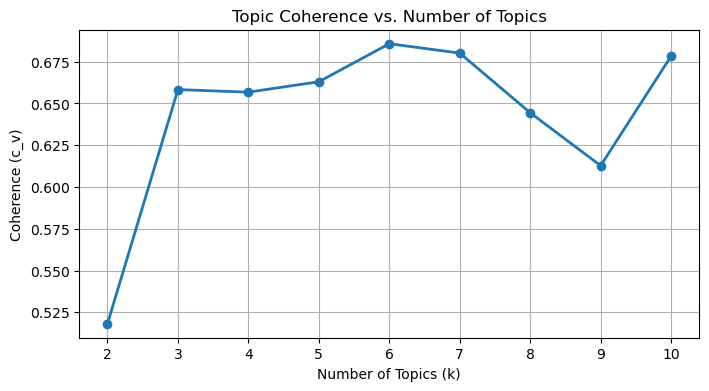

In [158]:
# Prepare your texts
df['Texto_Lematizado'] = df['Texto_Lematizado'].fillna('')
texts = df['Texto_Lematizado'].tolist()
Ks    = range(2, 11)

# Compute and plot coherences
coh_scores = compute_coherence(Ks, texts, stop_list, topn=10)
plt.figure(figsize=(8, 4))
plt.plot(list(Ks), coh_scores, 'o-', linewidth=2)
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence (c_v)')
plt.title('Topic Coherence vs. Number of Topics')
plt.grid(True)
plt.show()

## Fit Final LDA

In [159]:
optimal_k = 4
vec = CountVectorizer(
    stop_words=stop_list,  # <— now uses your custom list
    min_df=10,
    max_df=0.95
)
dtm = vec.fit_transform(texts)

lda = LatentDirichletAllocation(
    n_components=optimal_k,
    random_state=42,
    max_iter=20
)
lda.fit(dtm)

LatentDirichletAllocation(max_iter=20, n_components=4, random_state=42)

In [160]:
def show_topics(model, feature_names, n_top=10):
    rows = []
    for idx, comp in enumerate(model.components_):
        top = [feature_names[i] for i in comp.argsort()[:-n_top-1:-1]]
        rows.append((idx, top))
    return pd.DataFrame(rows, columns=['Topic', 'Top Words'])

In [161]:
topics_df = show_topics(lda, vec.get_feature_names_out())
pd.set_option("display.max_colwidth", None)
display(topics_df)

,Topic,Top Words
0,0,"[beach, walk, view, water, sand, parking, clean, restaurant, quiet, wave]"
1,1,"[room, hotel, clean, breakfast, staff, night, bed, comfortable, bathroom, shower]"
2,2,"[visit, museum, house, history, interesting, portuguese, space, tour, family, host]"
3,3,"[food, service, restaurant, delicious, price, staff, wine, dish, eat, quality]"


## Topic Assignment & Analysis

In [162]:
doc_topics = lda.transform(dtm)           # matrix shape (n_docs, k)
df[['Topic_'+str(i) for i in range(optimal_k)]] = pd.DataFrame(doc_topics)
df['dominant_topic'] = df[['Topic_'+str(i) for i in range(optimal_k)]].idxmax(axis=1)

## Cross-tab with Clusters

In [163]:
composite.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo', 'shrinkage', 'Rating_Bayes', 'Nome_Local',
       'Avg_Polarity', 'Rating_Bayes_norm', 'Popularity_norm',
       'Sentiment_norm', 'IGATP', 'cluster_k2', 'cluster_k3', 'cluster_k6',
       'cluster_k7', 'cluster_k8', 'cluster_k9', 'cluster_k7_pam',
       'cluster_k6_pam'],
      dtype='object')

In [170]:
df.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média', 'Topic_0',
       'Topic_1', 'Topic_2', 'Topic_3', 'dominant_topic'],
      dtype='object')

In [175]:
df_final = df.merge(
    composite[['Nome_Local','cluster_k6_pam']],
    on='Nome_Local',
    how='left'
)

ct = pd.crosstab(df_final['dominant_topic'], df_final['cluster_k6_pam'])
print(ct)

cluster_k6_pam  1.0  2.0  3.0  4.0
dominant_topic                    
Topic_0         158  360  143   16
Topic_1         193  656  375  215
Topic_2         203  370  160   16
Topic_3         877  978  210   28


In [180]:
df_final.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média', 'Topic_0',
       'Topic_1', 'Topic_2', 'Topic_3', 'dominant_topic', 'cluster_k6_pam'],
      dtype='object')

In [181]:
# Ver os comentários associados ao cluster 0
comentarios_cluster_0 = df_final[df_final["cluster_k6_pam"] == 0]

# Ver os comentários associados ao cluster 5
comentarios_cluster_5 = df_final[df_final["cluster_k6_pam"] == 5]

# Opcional: visualizar colunas relevantes
print(comentarios_cluster_0[["Nome_Local", "Texto", "dominant_topic"]])
print(comentarios_cluster_5[["Nome_Local", "Texto", "dominant_topic"]])

Empty DataFrame
Columns: [Nome_Local, Texto, dominant_topic]
Index: []
Empty DataFrame
Columns: [Nome_Local, Texto, dominant_topic]
Index: []


In [186]:
df_final[df_final['Texto'] == ' '].count().sum()

0

In [187]:
df_final['Texto'].isnull().sum()

0

In [176]:
df_final.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média', 'Topic_0',
       'Topic_1', 'Topic_2', 'Topic_3', 'dominant_topic', 'cluster_k6_pam'],
      dtype='object')

In [177]:
df_final.to_csv("ratings_polarity_lda_topics.csv", index=False)